# Spatial Feature Engineering (II)

## Map Synthesis

## 📖 Ahead of time...

In this second part of Spatial Feature Engineering, we turn to Map Synthesis. There is only one reading to complete for this block, [Chapter 12](https://geographicdata.science/book/notebooks/12_feature_engineering.html) of the GDS Book {cite}`reyABwolf`. This block of Spatial Feature Engineering in this course loosely follows the second part of the chapter ([Map Synthesis](https://geographicdata.science/book/notebooks/12_feature_engineering.html#feature-engineering-using-map-synthesis)).

## 💻 Hands-on coding

In [1]:
import pandas, geopandas
import numpy as np
import contextily
import tobler


```{margin} Data
If you want to read more about the data sources behind this dataset, head to the [Datasets](../data/datasets) section
```



````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
pts = geopandas.read_file("../data/madrid_abb.gpkg")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
pts = geopandas.read_file(
    "https://github.com/GDSL-UL/san/raw/v0.1.0/data/assignment_1_madrid/madrid_abb.gpkg"
)
```
````

In [2]:
pts = geopandas.read_file("../data/madrid_abb.gpkg")

We will be working with a modified version of `pts`:

- Since we will require distance calculations, we will switch to the Spanish official projection
- To make calculations in the illustration near-instantaneous, we will work with a smaller (random) sample of Airbnb properties (10% of the total)

In [3]:
db = pts.sample(
    frac=0.1, random_state=123
).to_crs(epsg=25830)

As you can see in the description, the new CRS is expressed in metres:

In [4]:
db.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Distance buffers

*How many Airbnb's are within 500m of each Airbnb?*

In [5]:
from pysal.lib import weights

Using `DistanceBand`, we can build a spatial weights matrix that assigns `1` to each observation within 500m, and `0` otherwise.

In [6]:
%%time
w500m = weights.DistanceBand.from_dataframe(
    db, threshold=500, binary=True
)

CPU times: user 283 ms, sys: 16.8 ms, total: 300 ms
Wall time: 303 ms


/opt/conda/envs/gds/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 86 disconnected components.
 There are 47 islands with ids: 6878, 16772, 15006, 1336, 3168, 15193, 1043, 5257, 4943, 12849, 10609, 11309, 10854, 10123, 3388, 9380, 10288, 13071, 3523, 15316, 3856, 205, 7720, 10454, 18307, 3611, 12405, 10716, 14813, 15467, 1878, 16597, 14329, 7933, 16215, 13525, 13722, 11932, 14456, 8848, 15197, 8277, 9922, 13072, 13852, 5922, 17151.
  warnings.warn(message)


The number of neighbors can be accessed through the `cardinalities` attribute:

In [7]:
n_neis = pandas.Series(w500m.cardinalities)
n_neis.head()

11297    213
2659       5
16242     21
15565      9
14707    159
dtype: int64

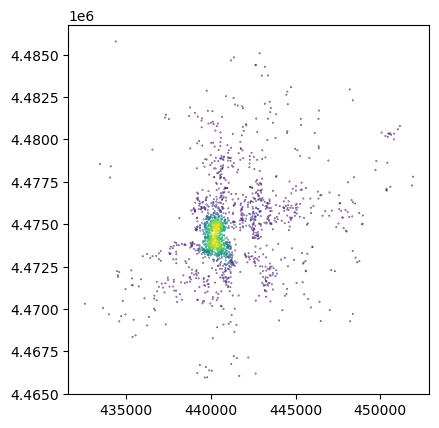

In [8]:
db.assign(
    n_neis=n_neis
).plot("n_neis", markersize=0.1);

```{admonition} Challenge
Calculate the number of AirBnb properties within 250m of each other property. *What is the average?*
```

### Distance rings

*How many Airbnb's are between 500m and 1km of each Airbnb?*

In [9]:
%%time
w1km = weights.DistanceBand.from_dataframe(
    db, threshold=1000, binary=True
)

CPU times: user 915 ms, sys: 67.5 ms, total: 982 ms
Wall time: 995 ms


/opt/conda/envs/gds/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 5 islands with ids: 4943, 12849, 15467, 13525, 11932.
  warnings.warn(message)


Now, we could do simply a subtraction:

In [10]:
n_ring_neis = pandas.Series(w1km.cardinalities) - n_neis

Or, if we need to know *which is which*, we can use set operations on weights:

In [11]:
w_ring = weights.w_difference(w1km, w500m, constrained=False)

/opt/conda/envs/gds/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 34 disconnected components.
 There are 23 islands with ids: 3744, 4143, 4857, 4943, 6986, 8345, 8399, 9062, 10592, 10865, 11574, 11613, 11785, 11840, 11932, 12015, 12635, 12714, 12849, 13091, 13317, 13525, 15467.
  warnings.warn(message)


And we can confirm they're both the same:

In [12]:
(pandas.Series(w_ring.cardinalities) - n_ring_neis).sum()

0

```{admonition} Challenge
Can you create a plot with the following two lines?

- One depicting the average number of properties within a range of 50m, 100m, 250m, 500m, 750m
- Another one with the _increase_ of average neighbors for the same distances above
```

### Cluster membership (points)

We can use the spatial configuration of observations to classify them as part of clusters or not, which can then be encoded, for example, as dummy variables in a model.

```{margin}
These *magic* numbers need to be pre-set and you can play with both `min_pct` (or `min_pts` directly) and `eps` to see how they affect the results (spoiler: a lot!)
```

In [13]:
from sklearn.cluster import DBSCAN

min_pct = 2
min_pts = len(db) * min_pct // 100
eps = 500

We will illustrate it with a minimum number of points of `min_pct` % of the sample and a maximum radious of `eps` metres.

In [14]:
model = DBSCAN(min_samples=min_pts, eps=eps)
model.fit(
    db.assign(
        x=db.geometry.x
    ).assign(
        y=db.geometry.y
    )[['x', 'y']]
);

We will attach the labels to `db` for easy access:

In [15]:
db["labels"] = model.labels_

We can define boundaries to turn point clusters into polygons if that fits our needs better:

````{margin}
```{attention}
The code in this cell is a bit more advanced than expected for this course, but is used here as an illustration.
```
````

In [16]:
from pysal.lib import cg

boundaries = []
cl_ids = [i for i in db["labels"].unique() if i!=-1]
for cl_id in cl_ids:
    sub = db.query(f"labels == {cl_id}")
    cluster_boundaries = cg.alpha_shape_auto(
        np.array(
            [sub.geometry.x, sub.geometry.y]
        ).T,
    )
    boundaries.append(cluster_boundaries)
boundaries = geopandas.GeoSeries(
    boundaries, index=cl_ids, crs=db.crs
)

And we can see what the clusters look like:

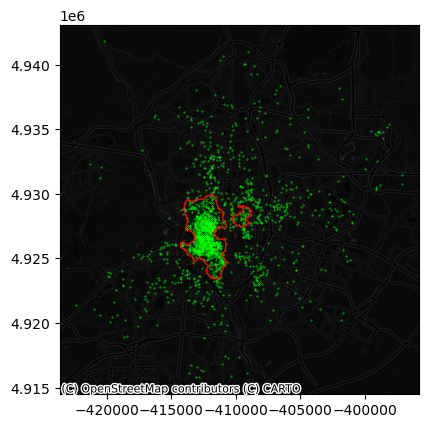

In [17]:
ax = db.to_crs(
    epsg=3857
).plot(
    markersize=0.1, color="lime"
)
boundaries.to_crs(
    epsg=3857
).plot(
    ax=ax, edgecolor="red", facecolor="none"
)
contextily.add_basemap(
    ax,
    source=contextily.providers.CartoDB.DarkMatterNoLabels
)

```{admonition} Challenge
*How does the map above change if you require 5% of points instead of 2% for a candidate cluster to be considered so?*
```

### Cluster membership (polygons)

We can take a similar approach as above if we have polygon geographies instead of points. Rather than using DBSCAN, here we can rely on local indicators of spatial association (LISAs) to pick up spatial concentrations of high or low values.

For the illustration, we will aggregate the location of Airbnb properties to a regular hexagonal grid, similar to how we generated it when {ref}`transfering from polygons to polygons <sfe_p2p>`. First we create a polygon covering the extent of points:

In [18]:
one = geopandas.GeoSeries(
    [cg.alpha_shape_auto(
        np.array(
            [db.geometry.x, db.geometry.y]
        ).T,
    )],
    crs=db.crs
)

Then we can tessellate:

In [19]:
abb_hex = tobler.util.h3fy(
    one, resolution=8
)

/opt/conda/envs/gds/lib/python3.9/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


And obtain a count of points in each polygon:

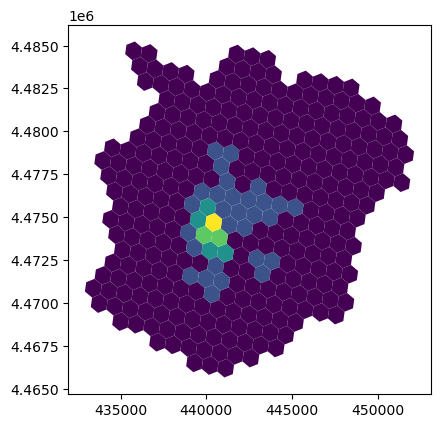

In [20]:
counts = geopandas.sjoin(
    db, abb_hex
).groupby(
    "index_right"
).size()

abb_hex["count"] = counts
abb_hex["count"] = abb_hex["count"].fillna(0)

abb_hex.plot("count", scheme="fisherjenks");

To identify spatial clusters, we rely on `esda`:

In [21]:
from pysal.explore import esda

/opt/conda/envs/gds/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/envs/gds/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/envs/gds/lib/python3.9/site-packages/quantecon/lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be chang

And compute the LISA statistics:

In [22]:
w = weights.Queen.from_dataframe(abb_hex)
lisa = esda.Moran_Local(abb_hex["count"], w)

/tmp/ipykernel_2683/2473509840.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(abb_hex)


For a visual inspection of the clusters, `splot`:

In [23]:
from pysal.viz import splot
from splot.esda import lisa_cluster

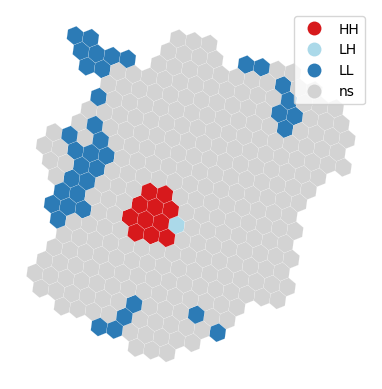

In [24]:
lisa_cluster(lisa, abb_hex, p=0.01);

And, if we want to extract the labels for each polygon, we can do so from the `lisa` object:

In [25]:
lisa.q * (lisa.p_sim < 0.01)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0,
       1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3,

## 🐾 Next steps

If you want a bit more background into some of the techniques reviewed in this block, the following might be of interest:

- [Block E](http://darribas.org/gds_course/content/bE/concepts_E.html) of the GDS Course {cite}`darribas_gds_course` will introduce you to more techniques like the LISAs seen above to explore the spatial dimension of the statistical properties of your data. If you want a more detailed read, [Chapter 4](https://geographicdata.science/book/notebooks/04_spatial_weights.html) of the GDS Book {cite}`reyABwolf` will do just that.
- [Block F](http://darribas.org/gds_course/content/bF/concepts_F.html) of the GDS Course {cite}`darribas_gds_course` will introduce you to more techniques like the LISAs seen above to explore the spatial dimension of the statistical properties of your data. If you want a more detailed read, [Chapter 7](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html) of the GDS Book {cite}`reyABwolf` will do just that.
- [Block H](http://darribas.org/gds_course/content/bH/concepts_H.html) of the GDS Course {cite}`darribas_gds_course` will introduce you to more techniques for exploring point patterns. If you want a more comprehensive read, [Chapter 8](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html) of the GDS Book {cite}`reyABwolf` will do just that.